In [1]:
!pip install pandas numpy matplotlib opencv-python
import pandas as pd, numpy as np, matplotlib.pyplot as plt, tensorflow as tf, os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers as tfl, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image 
import cv2
import sys
from tensorflow.keras.utils import to_categorical

2025-01-12 00:44:15.636182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736622855.647501   48355 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736622855.651078   48355 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 00:44:15.664274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = []
labels = []
import glob
galaxy_path = glob.glob('galaxy/*')
star_path = glob.glob('star/*')
for x in galaxy_path:
    image = cv2.imread(x, 1)
    image = np.array(image)
    data.append(image)
    labels.append(0)
for x in star_path:
    image = cv2.imread(x, 1)
    image = np.array(image)
    data.append(image)
    labels.append(1)

In [3]:
data, labels= np.array(data), np.array(labels)
dataset = pd.DataFrame(list(zip(data, labels)), columns = ['images', 'labels'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state = 42, shuffle = True, stratify = dataset['labels'].values)
X_test, X_valid, y_test, y_valid= train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

In [5]:
y_train, y_valid = to_categorical(y_train), to_categorical(y_valid)

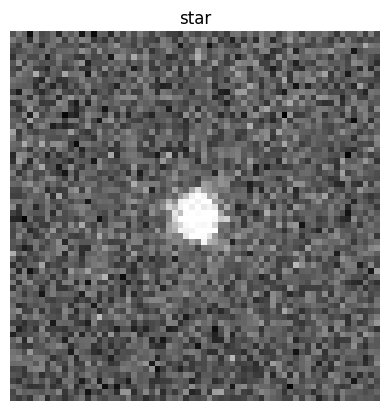

In [6]:
def show_img(x, y, index):
    plt.imshow(x[index])
    if y[index] == 0:
        plt.title('galaxy')
    else:
        plt.title('star')
    plt.axis('off')
    plt.show()

show_img(X_test, y_test, 11)

In [7]:
def identity_block(x_img, filters):

    #layer 1
    conv11 = tfl.Conv2D(filters, kernel_size=5, padding='same')(x_img)
    batch11 = tfl.BatchNormalization()(conv11)
    act11 = tfl.Activation('relu')(batch11)

    #layer 2
    conv21 = tfl.Conv2D(filters, kernel_size=5, padding='same')(x_img)
    batch21 = tfl.BatchNormalization()(conv21)

    x_add = tfl.Add()([x_img, batch21])
    x_identity = tfl.Activation('relu')(x_add)

    return x_identity

def conv_block(x_img, filters):

    conv11 = tfl.Conv2D(filters, kernel_size=3, padding='same', strides=2)(x_img)
    batch11 = tfl.BatchNormalization()(conv11)
    act11 = tfl.Activation('relu')(batch11)

    conv21 = tfl.Conv2D(filters, kernel_size=3, padding='same')(act11)
    batch21 = tfl.BatchNormalization()(conv11)

    conv_blk = tfl.Conv2D(filters, kernel_size=1, padding='same', strides=2)(x_img)

    x_add = tfl.Add()([batch11, conv_blk])
    x_conv = tfl.Activation('relu')(x_add)

    return x_conv

def resnet_model(classes, shape=(256, 256, 3)):

    x=tfl.Input(shape)
    x_rescaled = tfl.Rescaling(scale=1./256)(x)

    c1 = tfl.Conv2D(64, kernel_size=7, strides=2, padding='same')(x_rescaled)
    b1 = tfl.BatchNormalization()(c1)
    a1 = tfl.Activation('relu')(b1)
    pool1 = tfl.MaxPool2D(strides=(2, 2), pool_size=3)(a1)

    #1st Identity Block
    iden_layer1 = identity_block(pool1, 64)
    iden_layer2 = identity_block(iden_layer1, 64)
    iden_layer3 = identity_block(iden_layer2, 64)

    conv_layer1 = conv_block(iden_layer3, 128)

    iden_layer1 = identity_block(conv_layer1, 128)
    iden_layer2 = identity_block(iden_layer1, 128)
    iden_layer3 = identity_block(iden_layer2, 128)

    conv_layer1 = conv_block(iden_layer3, 256)

    iden_layer1 = identity_block(conv_layer1, 256)
    iden_layer2 = identity_block(iden_layer1, 256)
    iden_layer3 = identity_block(iden_layer2, 256)

    conv_layer1 = conv_block(iden_layer3, 512)

    iden_layer1 = identity_block(conv_layer1, 512)
    iden_layer2 = identity_block(iden_layer1, 512)
    iden_layer3 = identity_block(iden_layer2, 512)

    avg_pool = tfl.AveragePooling2D((2, 2), padding='same')(iden_layer2)
    flat = tfl.Flatten()(avg_pool)
    d1 = tfl.Dense(1024, activation = 'relu')(flat)
    d2 = tfl.Dense(classes, activation = 'sigmoid')(d1)
    model = tf.keras.models.Model(inputs = x, outputs = d2, name = 'RESNET_IN_ARCH')

    return model
    
    

In [8]:
model = resnet_model(2,(64,64,3))

2025-01-12 00:44:17.515360: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
model.summary()

Model: "RESNET_IN_ARCH"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 64, 64, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      9,472 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │    102,464 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 15,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 15, 15,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │    102,464 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 15, 15,    │          0 │ activation_2[0][… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 15, 15,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 15, 15,    │    102,464 │ activation_4[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 15, 15,    │          0 │ activation_4[0][

 Total params: 21,833,026 (83.29 MB)

 Trainable params: 21,826,370 (83.26 MB)

 Non-trainable params: 6,656 (26.00 KB)

In [10]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)


In [11]:
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [12]:
model.compile(optimizer= optimizers.Adam(learning_rate=0.01),
             loss='binary_crossentropy',
                    metrics=METRICS)

In [13]:
import os
paths = {'model_path' : os.path.join('models'), 
         'weights_path' : os.path.join('models','weights'),
         'saved_model_path' : os.path.join('models', 'saved_model'),
         'checkpoint_path' : os.path.join('models','checkpoints')
        }


In [14]:
for key, value in paths.items():
    if not os.path.exists(value):
        !mkdir {value}

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_ckpt= ModelCheckpoint(
                        filepath='models/checkpoints/model.keras', monitor='val_auc', verbose=0, save_best_only=True,
                         mode='max', save_freq='epoch')

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2,
                              patience=4, min_lr=0.001)

es = EarlyStopping(monitor='val_prc', mode='auto', verbose=1,
                  restore_best_weights=True)

In [16]:
history_resnet = model.fit(X_train, y_train,
                           validation_data=(X_valid, y_valid),
                    epochs=25,
                    verbose=1,
                    batch_size=128,
                          callbacks=[model_ckpt,reduce_lr])


Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6786 - auc: 0.6544 - fn: 606.5667 - fp: 589.1000 - loss: 11.1158 - prc: 0.6136 - precision: 0.6839 - recall: 0.6577 - tn: 1382.3000 - tp: 1364.8334 - val_accuracy: 0.7450 - val_auc: 0.7450 - val_fn: 51.0000 - val_fp: 51.0000 - val_loss: 3325.3943 - val_prc: 0.7067 - val_precision: 0.7450 - val_recall: 0.7450 - val_tn: 149.0000 - val_tp: 149.0000 - learning_rate: 0.0100
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7662 - auc: 0.8104 - fn: 479.4667 - fp: 462.5667 - loss: 0.5358 - prc: 0.7933 - precision: 0.7679 - recall: 0.7630 - tn: 1508.8334 - tp: 1491.9333 - val_accuracy: 0.2550 - val_auc: 0.2550 - val_fn: 149.0000 - val_fp: 149.0000 - val_loss: 80.8589 - val_prc: 0.3670 - val_precision: 0.2550 - val_recall: 0.2550 - val_tn: 51.0000 - val_tp: 51.0000 - learning_rate: 0.0100
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6636 - auc: 0.7247 - fn: 629.5000 - fp: 623.6334 - loss: 0.6220 - p